In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as Data

from torchsummary import summary

In [2]:
import yfinance as yf

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
data = pd.read_csv("TSLA.csv")
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-10-19,45.30,46.23,44.99,45.62,12539500,0,0.0
1,2015-10-20,45.54,45.72,40.40,42.61,74500000,0,0.0
2,2015-10-21,42.40,42.96,41.76,42.02,20757500,0,0.0
3,2015-10-22,42.31,43.15,41.88,42.34,14126000,0,0.0
4,2015-10-23,43.00,43.07,41.54,41.82,21177500,0,0.0
...,...,...,...,...,...,...,...,...
1254,2020-10-12,442.00,448.74,438.58,442.30,38791100,0,0.0
1255,2020-10-13,443.35,448.89,436.60,446.65,34463700,0,0.0
1256,2020-10-14,449.78,465.90,447.35,461.30,48045400,0,0.0
1257,2020-10-15,450.31,456.57,442.50,448.88,35554200,0,0.0


<AxesSubplot:>

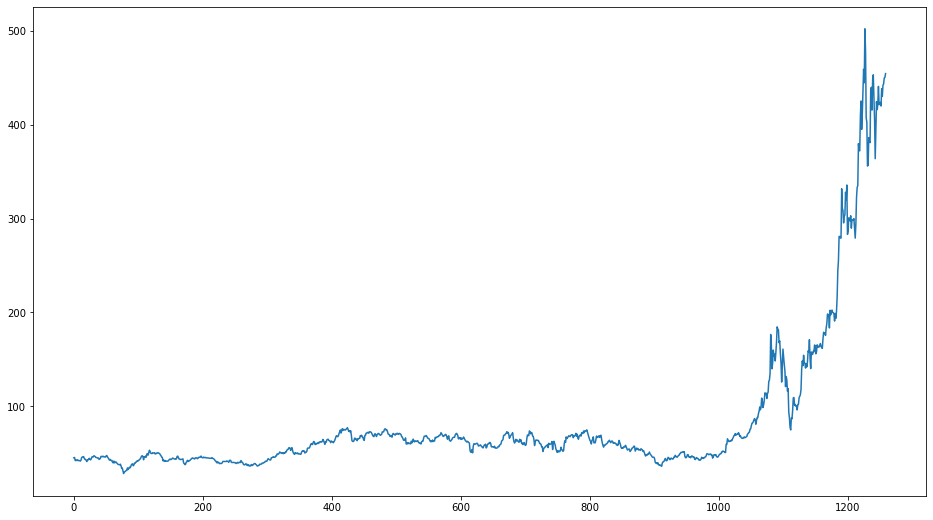

In [5]:
data['Open'].plot(figsize=(16, 9))

In [6]:
dataset_train = data
training_set = dataset_train.iloc[:, 1:2].values

In [7]:
len(training_set)

1259

In [8]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [9]:
X_train = []
y_train = []
for i in range(60, len(training_set)-200):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)

In [10]:
X_train.shape

torch.Size([999, 60])

In [11]:
y_train = y_train.reshape(1, len(X_train), -1)

In [12]:
y_train.shape

torch.Size([1, 999, 1])

In [13]:
X_train = X_train.reshape(1, len(X_train), 60)

In [14]:
X_train.shape

torch.Size([1, 999, 60])

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=4, dropout=0.2)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, inputs):
        output, hidden = self.lstm(inputs)
        out = self.linear(output)
        return(out)

In [16]:
model = LSTM(60, 70)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
model.to(device)

LSTM(
  (lstm): LSTM(60, 70, num_layers=4, dropout=0.2)
  (linear): Linear(in_features=70, out_features=1, bias=True)
)

In [18]:
X_train = X_train.to(device)
X_train.device

device(type='cuda', index=0)

In [19]:
y_train = y_train.to(device)
y_train.device

device(type='cuda', index=0)

In [20]:
n_epochs = 1000
for epoch in range(n_epochs):
    model.zero_grad()
    y_pred = model(X_train)
    loss= loss_function(y_pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch%10==0:
        print("Epoch: ", epoch+1, "| Loss: ", float(loss))

Epoch:  1 | Loss:  0.002523618284612894
Epoch:  11 | Loss:  0.0007967379060573876
Epoch:  21 | Loss:  0.0005939420661889017
Epoch:  31 | Loss:  0.0006191811407916248
Epoch:  41 | Loss:  0.0006042623426765203
Epoch:  51 | Loss:  0.0005843277904205024
Epoch:  61 | Loss:  0.0005764116067439318
Epoch:  71 | Loss:  0.0005616816924884915
Epoch:  81 | Loss:  0.0004945988766849041
Epoch:  91 | Loss:  0.0002980066929012537
Epoch:  101 | Loss:  0.0002227638615295291
Epoch:  111 | Loss:  0.00018132870900444686
Epoch:  121 | Loss:  0.00016627809964120388
Epoch:  131 | Loss:  0.000138866322231479
Epoch:  141 | Loss:  0.0001169874012703076
Epoch:  151 | Loss:  0.00010994190233759582
Epoch:  161 | Loss:  9.118253365159035e-05
Epoch:  171 | Loss:  8.30958888400346e-05
Epoch:  181 | Loss:  8.25399620225653e-05
Epoch:  191 | Loss:  7.46167206671089e-05
Epoch:  201 | Loss:  6.887879862915725e-05
Epoch:  211 | Loss:  6.371843483066186e-05
Epoch:  221 | Loss:  6.719672092003748e-05
Epoch:  231 | Loss:  6.0

In [21]:
model.to("cpu")

LSTM(
  (lstm): LSTM(60, 70, num_layers=4, dropout=0.2)
  (linear): Linear(in_features=70, out_features=1, bias=True)
)

## Test

In [23]:
# Getting the stock price of 2020
dataset_test = pd.read_csv("TSLA.csv")
dataset_test = dataset_test.iloc[-200:]
len(dataset_test)

200

In [24]:
real_stock_price = dataset_test.iloc[:, 1:2].values

In [25]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = torch.Tensor(X_test)
X_test = X_test.reshape(1, len(X_test), 60)
predicted_stock_price = model(X_test)
predicted_stock_price = torch.Tensor.cpu(predicted_stock_price).detach().numpy()[-1]
predicted_stock_price = sc.inverse_transform(np.array(predicted_stock_price))

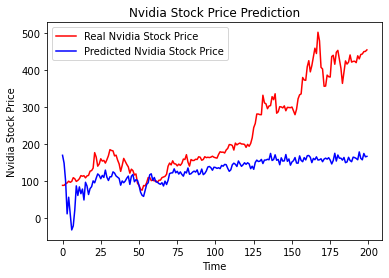

In [26]:
plt.plot(real_stock_price, color = 'red', label = 'Real Tesla Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()